# Regression Project: RDD model 
## Use RDD to estimate the effect of the following events in Quebec:
### 1. The 20/3/2020 lockdown
### 2. The reopening of schools on 31/8/2020
### 3. The 25/12/2020 lockdown

**Data extracted from https://www.inspq.qc.ca/covid-19/donnees **


In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 
import statsmodels.api as sm
import pandas as pd

#create covid table contains all the confirmed cases in from the beginning until now:

df = pd.read_csv("../project2/20mar2020.csv")
df.head()

#drop redundant columns 
covid = df.drop(columns = ['Moyenne mobile (7 jours)', 'Annotations 1'])
covid
covid["Date de résultat du test"] = pd.to_datetime(covid["Date de résultat du test"])
covid.rename(columns = {'Date de résultat du test':'Result_Date','Cas confirmés':'confirmed_cases'}, inplace = True)


## The 20/3/2020 lockdown:

In [2]:
#create dataset for 1st lockdown in MAR2020:
start_date = "2020-02-24"
end_date = "2020-04-20"

data = (covid['Result_Date'] >= start_date) & (covid['Result_Date'] <= end_date)
mar = covid.loc[data].reset_index()
mar['Day']=mar.index
mar = mar.drop('index',axis=1)
mar

,Result_Date,confirmed_cases,Day
0,2020-02-24,0,0
1,2020-02-25,0,1
2,2020-02-26,0,2
3,2020-02-27,0,3
4,2020-02-28,0,4
5,2020-02-29,0,5
6,2020-03-01,0,6
7,2020-03-02,0,7
8,2020-03-03,0,8
9,2020-03-04,0,9


In [3]:
#RDD basic:
# split dataset into groups: "Treatment" and "Control"
mar['Group'] = np.where(mar['Day']>= 25.5, "Treatment", "Control")
mar['Day_normalized'] = mar['Day'] - 25.5 
mar_control = mar[mar.Group=='Control']
mar_treatment = mar[mar.Group=='Treatment']

import statsmodels.formula.api as smf
#define regression discontinued model: Y = confirmed cases; 1 = intercept; C(Group) = category var
# Day_normalized = running var that determines the Group 
rd1 = " confirmed_cases ~ 1 + C(Group) + Day_normalized"
basic1 = smf.ols(rd1,mar).fit(cov_type="HC1")
print(basic1.summary())

                            OLS Regression Results                            
Dep. Variable:        confirmed_cases   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     186.1
Date:                Thu, 12 Jan 2023   Prob (F-statistic):           5.94e-25
Time:                        20:25:25   Log-Likelihood:                -356.04
No. Observations:                  57   AIC:                             718.1
Df Residuals:                      54   BIC:                             724.2
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               182.58

In [4]:
#according to the .ipynb from Aastha:
rdd_df = mar.assign(threshold=(mar["Day_normalized"] > 0).astype(float))

model = smf.wls("confirmed_cases ~ Day_normalized*threshold", rdd_df).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,20.8019,39.208,0.531,0.598,-57.839,99.442
Day_normalized,1.1593,2.612,0.444,0.659,-4.080,6.399
threshold,250.3598,53.161,4.709,0.000,143.732,356.987
Day_normalized:threshold,19.7834,3.294,6.006,0.000,13.177,26.390


/Users/danielledong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


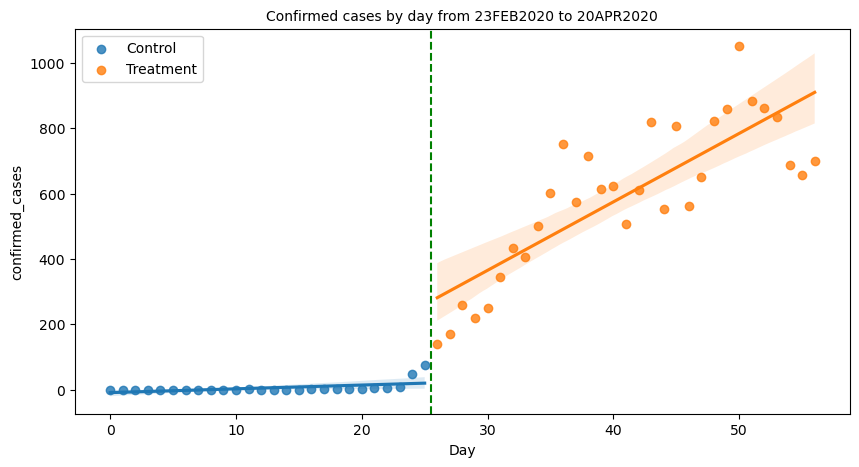

In [5]:
plt.figure(figsize = (10,5))
sns.regplot(mar_control.Day, mar_control.confirmed_cases,label = "Control").legend(loc="best")
sns.regplot(mar_treatment.Day, mar_treatment.confirmed_cases, label = "Treatment").legend(loc="best")
plt.axvline(25.5, 0, linestyle = "--", color = "green")
#plt.scatter(x=25.5, y=0, color='r')
plt.title('Confirmed cases by day from 23FEB2020 to 20APR2020', fontsize = 10)
plt.show()

# Explanation of effects before n after the lockdown:

 The Graph above is a scatterplot of data of before and after first lockdown due to covid cases in quebec. We have analyzed covid cases  between Feb 24th and April 20th and plotted the regression-discontinuity design with 95% confidence interval and r-squared(0.864) which indicates that our model fits well in data.
 
 We observe that the coefficient of our three variables that is intercept(182.5819),Day_normalized(13.6039) and T.Treatment is positive (C(Group)[T.Treatment] 202.3314)which indicates that the cases increases 182 times of the intercept , 13 times of the day_normalized and increases 202.33 times of T.Treatment value respectively.
 
 The 'confirmed cases' are plotted on the vertical axis and the 'Day' variable which was created based on the "Results_date" variable is plotted on the horizontal axis. The vertical green line indicates the cutoff score having values 25.5 on the horizontal line 'Day'.
The 'confirmed cases' with 'Day' above the cutoff are placed in the treatment group,
while the 'confirmed cases' with 'Day'  below the cutoff are placed in the control group. 

## Conclusion: 
Before lockdown:
From 24th feb 2020 to 20th mar2020 which is Day 0 to Day 25 before the lockdown period ,
we can see there were no any cases till day 10 and after this ,cases were increasing gradually  and after day25. We got a threshold value=25.5 where our regression line discontinued and rapid increment in cases.

As shown in the graph, the data-generating process was nonlinear; however, with straight lines to the left and right of the cutoff, the trends in the running variables generate a spurious discontinuity at the cutoff. This shows up in a regression as well. When we fit the model using a least squares regression controlling for the running variable, we estimate a casual effect though there isn’t one.


After lockdown:
After implementation of lockdown in Quebec on 20-03-2020 , the increasing trend in COVID-19 incidence reversed after 2 weeks.
Although rates were considerably higher after lockdown, rates declined markedly after april 14,which indicates that lockdown somehow helps to control the cases.  

## The reopening of schools on 31/8/2020

In [6]:
#create dataset for school opening AUG2020:
start_date = "2020-07-31"
end_date = "2020-09-30"

data = (covid['Result_Date'] >= start_date) & (covid['Result_Date'] <= end_date)
aug = covid.loc[data].reset_index()
aug['Day']=aug.index
aug = aug.drop('index',axis=1)
aug[aug.Result_Date == "2020-08-31"]

,Result_Date,confirmed_cases,Day
31,2020-08-31,133,31


In [7]:
#RDD basic:
# split dataset into groups: "Treatment" and "Control"
aug['Group'] = np.where(aug['Day']>= 31.5, "Treatment", "Control")
aug['Day_normalized'] = aug['Day'] - 31.5 
aug_control = aug[aug.Group=='Control']
aug_treatment = aug[aug.Group=='Treatment']

import statsmodels.formula.api as smf
#define regression discontinued model: Y = confirmed cases; 1 = intercept; C(Group) = category var
# Day_normalized = running var that determines the Group 
rd2 = " confirmed_cases ~ 1 + C(Group) + Day_normalized"
basic2 = smf.ols(rd2,aug).fit(cov_type="HC1")
print(basic2.summary())

                            OLS Regression Results                            
Dep. Variable:        confirmed_cases   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     39.79
Date:                Thu, 12 Jan 2023   Prob (F-statistic):           1.15e-11
Time:                        20:25:37   Log-Likelihood:                -399.11
No. Observations:                  62   AIC:                             804.2
Df Residuals:                      59   BIC:                             810.6
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               310.93

In [8]:
#according to the .ipynb from Aastha:
rdd_df2 = aug.assign(threshold=(aug["Day_normalized"] > 0).astype(float))

model2 = smf.wls("confirmed_cases ~ Day_normalized*threshold", rdd_df2).fit()

model2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,94.9337,26.103,3.637,0.001,42.683,147.185
Day_normalized,-0.4280,1.413,-0.303,0.763,-3.256,2.401
threshold,-81.3080,37.526,-2.167,0.034,-156.425,-6.191
Day_normalized:threshold,29.8863,2.102,14.215,0.000,25.678,34.095


/Users/danielledong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


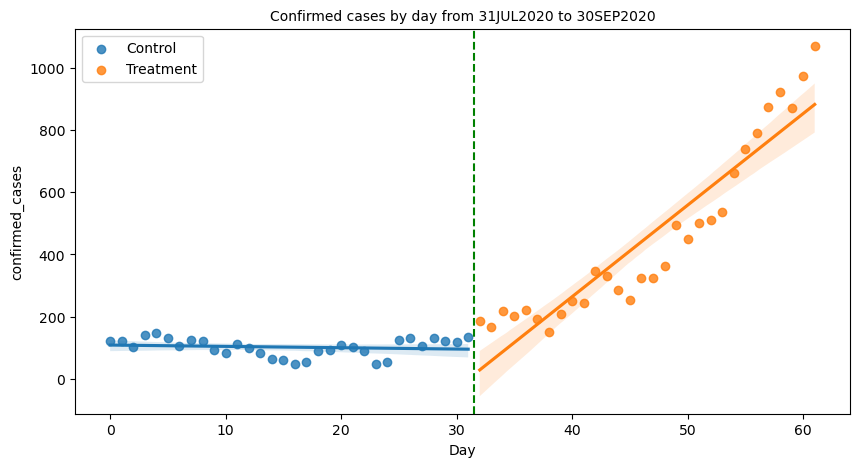

In [9]:
plt.figure(figsize = (10,5))
sns.regplot(aug_control.Day, aug_control.confirmed_cases, label = "Control").legend(loc="best")
sns.regplot(aug_treatment.Day, aug_treatment.confirmed_cases, label = "Treatment").legend(loc="best")
plt.axvline(31.5, 0, linestyle = "--", color = "green")
#plt.scatter(x=25.5, y=0, color='r')
plt.title('Confirmed cases by day from 31JUL2020 to 30SEP2020', fontsize = 10)
plt.show()


## Findings for The reopening of schools on 31/8/2020:

The graph is a scatterplot of data of before and after the reopening of schools due to covid cases in quebec. We have taken dataset  between 31st july and 30th september and plotted the regression-discontinuity design.

The p values of Day_normalized and Intercept are statistically significant (95%) . The coefficient of Day_normalized is positive (Day_normalized 13.0721) which means that as the days pass by,the probability of getting infected by covid-19 increases by 13 times of its value. As shown in the graph, the 'confirmed cases' are plotted on the vertical axis and the  'Days'variable is plotted on the horizontal axis. The vertical line indicates the cutoff score having values 31.5 on the horizontal line 'Day'. The 'confirmed cases' with 'Day'above the cutoff are placed in the  treatment group, while the 'confirmed cases' with 'Day'  below the cutoff are placed in the control group.

## Conclusion: 
Before opening of schools:

From July 31st 2020 to August 31st 2020 which is Day 0 to Day 31 before the lockdown period ,
we observe that cases were below 200 before reopening of schools and it fluctuates between these days.
We selected a threshold value=31.5 with straight lines to the left and right of the cutoff, the trends in the running variable which generates a discontinuity regression. We fit the model using a least squares regression controlling for the running variable.

After reopening of schools: After reopening of schools in Quebec on 31-08-2020 , cases increasing abruptly which indicates that after reopenings of school cases increases. 
 

## The 25/12/2020 lockdown

In [18]:
#create dataset for 2nd lockdown DEC2020:
start_date = "2020-11-25"
end_date = "2021-01-25"

data = (covid['Result_Date'] >= start_date) & (covid['Result_Date'] <= end_date)
dec = covid.loc[data].reset_index()
dec['Day']=dec.index
dec = dec.drop('index',axis=1)
dec
dec[dec.Result_Date=="2020-12-25"]

,Result_Date,confirmed_cases,Day
30,2020-12-25,2323,30


In [12]:
#RDD basic:
# split dataset into groups: "Treatment" and "Control"
dec['Group'] = np.where(dec['Day']>= 30.5, "Treatment", "Control")
dec['Day_normalized'] = dec['Day'] - 30.5 
dec_control = dec[dec.Group=='Control']
dec_treatment = dec[dec.Group=='Treatment']

import statsmodels.formula.api as smf
#define regression discontinued model: Y = confirmed cases; 1 = intercept; C(Group) = category var
# Day_normalized = running var that determines the Group 
rd3 = " confirmed_cases ~ 1 + C(Group) + Day_normalized"
basic3 = smf.ols(rd3,dec).fit(cov_type="HC1")
print(basic3.summary())

                            OLS Regression Results                            
Dep. Variable:        confirmed_cases   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     3.376
Date:                Tue, 10 Jan 2023   Prob (F-statistic):             0.0409
Time:                        21:09:33   Log-Likelihood:                -463.60
No. Observations:                  62   AIC:                             933.2
Df Residuals:                      59   BIC:                             939.6
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1700.96

In [13]:
#according to the .ipynb from Aastha:
rdd_df3 = dec.assign(threshold=(dec["Day_normalized"] > 0).astype(float))

model3 = smf.wls("confirmed_cases ~ Day_normalized*threshold", rdd_df3).fit()

model3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2329.9571,84.064,27.717,0.000,2161.685,2498.229
Day_normalized,34.0472,4.697,7.248,0.000,24.644,43.450
threshold,471.0734,118.884,3.962,0.000,233.101,709.046
Day_normalized:threshold,-81.1605,6.643,-12.217,0.000,-94.458,-67.863


/Users/danielledong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


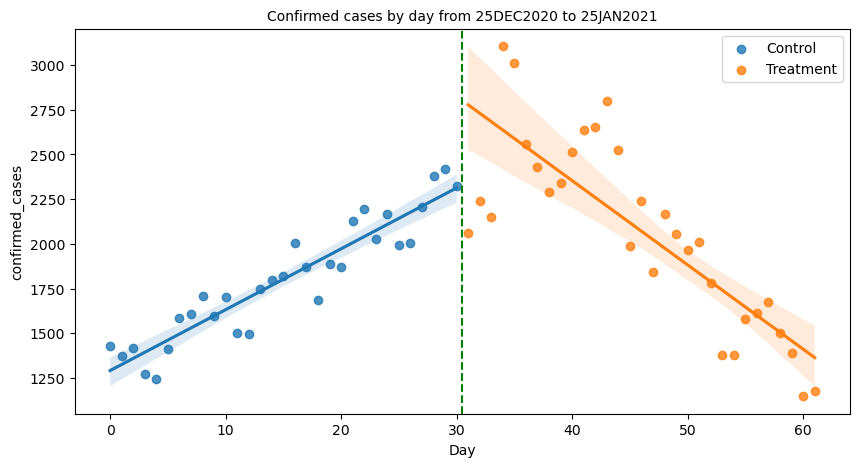

In [14]:
plt.figure(figsize = (10,5))
sns.regplot(dec_control.Day, dec_control.confirmed_cases, label = "Control").legend(loc="best")
sns.regplot(dec_treatment.Day, dec_treatment.confirmed_cases, label = "Treatment").legend(loc="best")
plt.axvline(30.5, 0, linestyle = "--", color = "green")

plt.title('Confirmed cases by day from 25DEC2020 to 25JAN2021', fontsize = 10)
plt.show()

## Discussion:

The above graph is a scatterplot of data between 25-11-2020 and 25-01-2021 of further lockdown  due to covid cases in quebec. We have three variables but only one variable (Intercept) of the regression coefficients was found to be statistically significant at the 95% confidence level, as indicated by their respective P-values. The coefficient (Intercept) is less than 0.05. We have plotted the rdd of  the 'confirmed cases' (y-axis) and the  'Day' variable is plotted on (x-axis). The vertical green line indicates the cutoff score having values 30.5 on the horizontal line 'Day'. The 'confirmed cases' with 'Day' above the cutoff are placed in the  treatment group, while the 'confirmed cases' with 'Day'  below the cutoff are placed in the control group.

# Conclusion: 

Before lockdown:
From November 25th 2020 and January 25th 2021 which is Day 0 to Day 25 before the lockdown period, we can see the cases were increasing rapidly till day 30 and reached 2323 (highest value). We selected a threshold value=30.5 where our regression line discontinued and cases started decreasing and reached below 1500.

After further lockdown:
After implementation of lockdown in Quebec on 25-12-2020 , the increasing trend in COVID-19 incidence reversed. Although rates were considerably higher but after implementation of lockdown we can see, rates declined rapidly which indicates that lockdown helps to control the cases again.

  

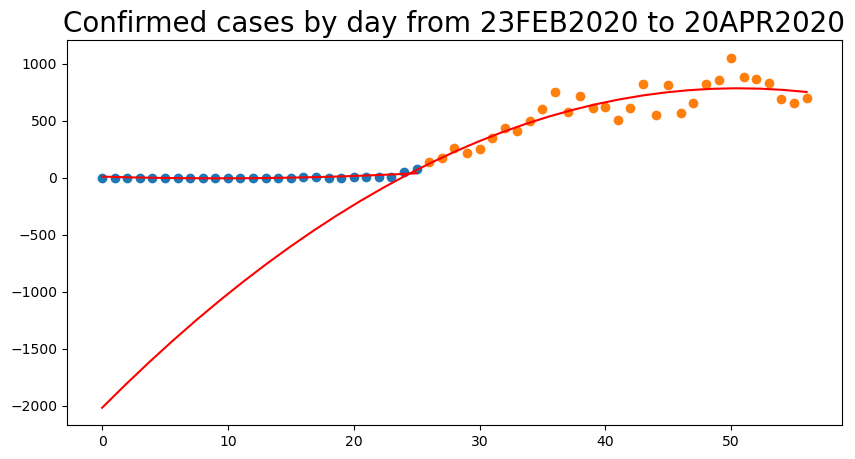

In [26]:
#Extra for polynomial feature 
#Apply squared function 
X1 = mar_control['Day']
X1 = pd.concat([X1, X1**2], axis=1)
X1 = sm.add_constant(X1)
y1 = mar_control['confirmed_cases']

est1 = sm.OLS(y1,X1).fit()

Xfit1 = pd.DataFrame(np.linspace(0, X1.iloc[:,1].max(),len(X1)))
Xfit1 = pd.concat([Xfit1, Xfit1**2], axis=1)
Xfit1 = sm.add_constant(Xfit1)


yfit1 = est1.predict(Xfit1)

##########################
X2 = mar_treatment['Day']
X2 = pd.concat([X2, X2**2], axis=1)
X2 = sm.add_constant(X2)
y2 = mar_treatment['confirmed_cases']

est2 = sm.OLS(y2,X2).fit()

Xfit2 = pd.DataFrame(np.linspace(0, X2.iloc[:,1].max(),len(X2)))
Xfit2 = pd.concat([Xfit2, Xfit2**2], axis=1)
Xfit2 = sm.add_constant(Xfit2)


yfit2 = est2.predict(Xfit2)

#plt.scatter(X.iloc[:,1], y)
#plt.plot(Xfit.iloc[:,1], yfit, color='red')

est2.summary()

plt.figure(figsize = (10,5))
plt.scatter(X1.iloc[:,1], y1)
plt.plot(Xfit1.iloc[:,1], yfit1, color='red')
plt.scatter(X2.iloc[:,1], y2)
plt.plot(Xfit2.iloc[:,1], yfit2, color='red')


plt.title('Confirmed cases by day from 23FEB2020 to 20APR2020', fontsize = 20)
plt.show()

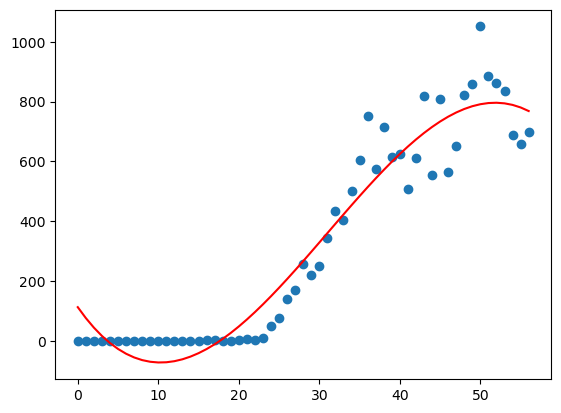

In [24]:
#combine cube & squared function 
X = mar['index']
X = pd.concat([X, X**2,X**3], axis=1)
X = sm.add_constant(X)
y = mar['Cas confirmés']

est = sm.OLS(y,X).fit()

Xfit = pd.DataFrame(np.linspace(0, X.iloc[:,1].max(),len(X)))
Xfit = pd.concat([Xfit, Xfit**2, Xfit**3], axis=1)
Xfit = sm.add_constant(Xfit)


yfit = est.predict(Xfit)

plt.scatter(X.iloc[:,1], y)
plt.plot(Xfit.iloc[:,1], yfit, color='red')